In [1]:
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

from sklearn.model_selection import train_test_split
from sklearn import metrics

import pandas as pd
from datetime import date

Using TensorFlow backend.


In [2]:
df_raw = pd.read_csv('data/train.csv')
df = df_raw.copy()

df['Age'] = df.Age.fillna(-1)
df['Embarked'] = df.Embarked.fillna('NA')

df = df.dropna()
y = df['Survived']
df = df.drop(columns=['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'])
X = pd.get_dummies(df)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_NA,Embarked_Q,Embarked_S
871,1,47.0,1,1,52.5542,1,0,0,0,0,1
430,1,28.0,0,0,26.5500,0,1,0,0,0,1
194,1,44.0,0,0,27.7208,1,0,1,0,0,0
124,1,54.0,0,1,77.2875,0,1,0,0,0,1
438,1,64.0,1,4,263.0000,0,1,0,0,0,1


In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_train)

In [6]:
X_scale.shape

(163, 11)

In [7]:
model =  Sequential()
model.add(Dense(3, input_dim=X_scale.shape[1], activation='relu'))
model.add(Dense(3, input_dim=X_scale.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

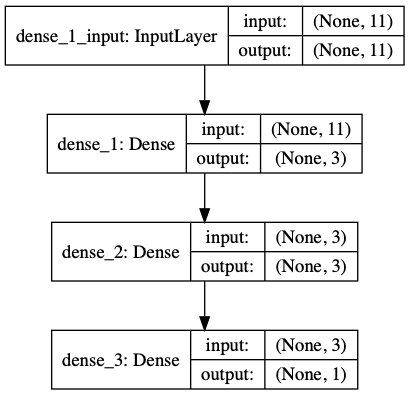

In [8]:
from keras.utils import plot_model
plot_model(model, to_file='model1.png',show_shapes=True,show_layer_names=True)

In [9]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
model.fit(X_train, y_train, epochs=300, batch_size=30, verbose=0)

In [12]:
prob1 = model.predict(X_val)

In [13]:
print(model.metrics_names)
print(model.evaluate(X_val, y_val,verbose=0))

['loss', 'accuracy']
[0.5794250252770214, 0.7560975551605225]


Text(0.5, 1.0, 'Probability of class 1')

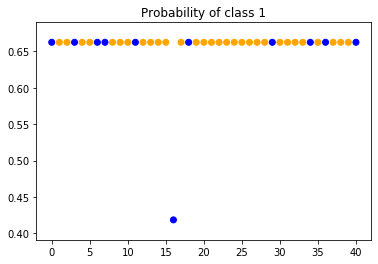

In [14]:
# plot predictions and true labels
# blue for class 0, orange for class 1
import matplotlib.pyplot as plt
color = ['blue' if y==0 else 'orange' for y in y_val]
plt.scatter(range(len(prob1)), prob1, color=color)
plt.title('Probability of class 1')

In [15]:
threshold = 0.6
pred1 = (prob1 > threshold).flatten()

print(metrics.confusion_matrix(y_val, pred1))

[[ 1 10]
 [ 0 30]]


In [16]:
# Test predictions
test = pd.read_csv('data/test.csv')
test['Age'] = test.Age.fillna(-1)
test['Embarked'] = test.Embarked.fillna('NA')
test['Fare'] = test.Fare.fillna(X_train.Fare.median())

ids = test['PassengerId']
test = test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
test = pd.get_dummies(test)
test['Embarked_NA'] = 0

X_test = scaler.transform(test)

In [17]:
y_test_prob = model.predict(X_test)
y_test_pred = pd.Series((y_test_prob.flatten() > threshold))

In [18]:
y_test_pred.value_counts()

False    360
True      58
dtype: int64

In [19]:
y_test_pred = y_test_pred.astype('int')

In [20]:
out = pd.DataFrame({'PassengerId': ids, 'Survived': y_test_pred})
out.to_csv('Titanic_DenseNN_' + str(date.today()) + '.csv', index=False)
# Kaggle score of 0.72248